In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import einops

from visionts import VisionTS
from monash import gluonts_util

### Load the model

In [2]:
ARCH = 'mae_base' # choose from {'mae_base', 'mae_large', 'mae_huge'}. We recommend 'mae_base'
DEVICE = 'cuda:3'

# The following code will automatically download MAE (base) checkpoint file into ./ckpt/ if not exists.
model = VisionTS(ARCH, ckpt_dir='./ckpt/').to(DEVICE)

### Define util functions

In [3]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')

def run(x, y, align_const, norm_const, periodicity):
    x = torch.Tensor(einops.rearrange(x, 't -> 1 t 1')).to(DEVICE)
    y = torch.Tensor(einops.rearrange(y, 't -> 1 t 1')).to(DEVICE)
    model.update_config(x.shape[1], y.shape[1], align_const=align_const, norm_const=norm_const, periodicity=periodicity)

    with torch.no_grad():
        y_pred, input_image, reconstructed_image = model.forward(x, export_image=True)

    x = x[:, -300:, :]
    plt.subplot(2, 2, 1)
    show_image(input_image[0, 0], 'input')

    plt.subplot(2, 2, 2)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.title('input time series')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    show_image(reconstructed_image[0, 0], 'reconstructed')

    plt.subplot(2, 2, 4)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred.cpu()[0, :, 0], label='pred')
    plt.title('forecasting')
    plt.legend()
    plt.tight_layout()

### Forecasting Monash Dataset

- Example 1: a time-series with significant periodicity.

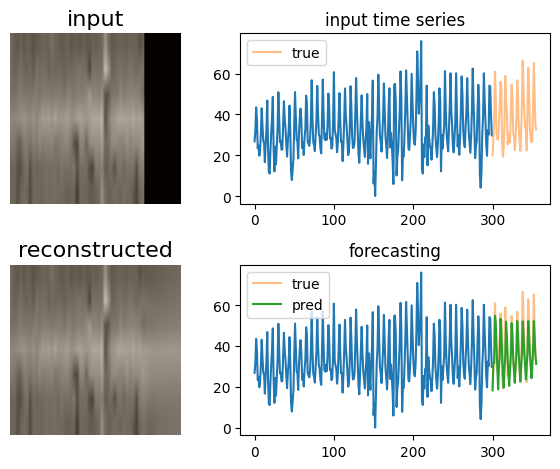

In [12]:
test_data, _ = gluonts_util.get_gluonts_test_dataset("nn5_daily_without_missing")
x = [x['target'] for x in test_data.input][0]
y = [x['target'] for x in test_data.label][0]

run(x[], y, align_const=1.0, norm_const=0.4, periodicity=7)

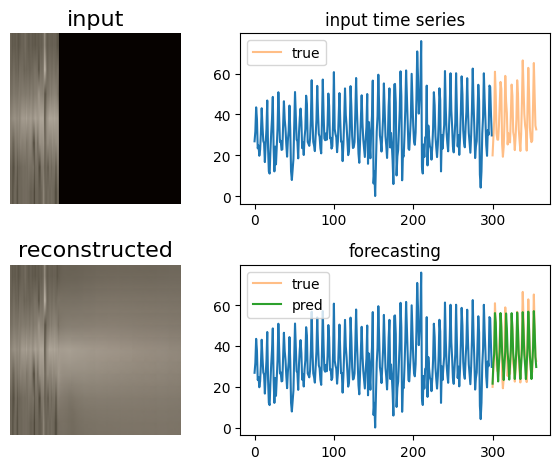

In [13]:
# Adjust align_const from 1.0 -> 0.4

run(x[-300:], y, align_const=0.4, norm_const=0.4, periodicity=7)

- Example 2: A time series without significant periodicity, but with a clear trend.

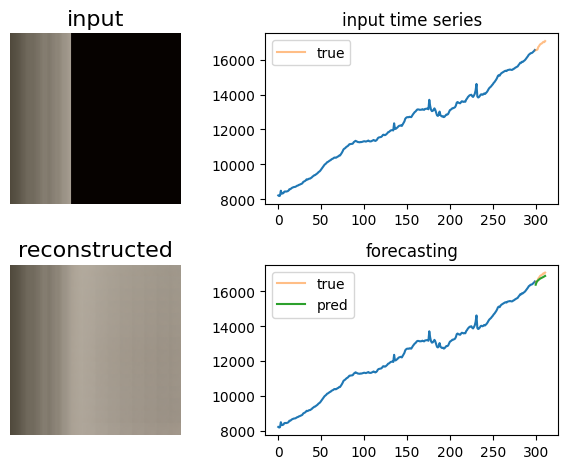

In [8]:
test_data, _ = gluonts_util.get_gluonts_test_dataset("fred_md")
x = [x['target'] for x in test_data.input][0]
y = [x['target'] for x in test_data.label][0]

run(x[-300:], y, align_const=0.4, norm_const=0.4, periodicity=1)